# Categorisez automatiquement des questions - Modelisation

In [1]:
%%script echo skipping
from google.colab import drive
drive.mount('/content/drive')

skipping


# SOMMAIRE
* [PREPARATION](#PREPARATION)
* [CHARGEMENT](#CHARGEMENT)
* [MODELISATION](#Modelisation)
    * [Bayes naïf](#Bayes-naïf)
    * [Random forest](#Random-forest)
    * [XGBoost](#XGBoost)
    * [Reseau de neurones](#Reseau-de-neurones)
    * [LDA](#LDA)

# PREPARATION

## import des librairies

In [2]:
import joblib
import pandas as pd
import matplotlib as mplt
import matplotlib.pyplot as plt
from matplotlib import cm #colormap
import numpy as np

import seaborn as sns
import re

from sklearn.decomposition import LatentDirichletAllocation

from sklearn.model_selection import train_test_split
from sklearn import naive_bayes
from sklearn.metrics import r2_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier

from sklearn import linear_model

from xgboost import XGBClassifier

import tensorflow as tf

## Paramétrage du notebook

In [3]:
from matplotlib import font_manager

font_dirs = ['/Library/Fonts/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# set font
plt.rcParams['font.family'] = 'Comic Sans'
plt.rcParams['font.sans-serif'] = 'Franklin Gothic Book'

In [4]:
sns.set(rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'lightgrey',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'axes.labelcolor': 'dimgrey',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'dimgrey',
 'xtick.bottom': False,
 'xtick.color': 'dimgrey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'dimgrey',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})

#mplt.font_manager._rebuild()
#mplt.font_manager.findfont('Franklin Gothic Book',rebuild_if_missing=True)


pd.options.display.max_colwidth=200
pd.options.display.min_rows=25
pd.options.display.max_columns=50

## Declaration des fonctions

In [5]:
def confusionMatrixAcc(y_true, y_pred):
    """
    Fonction qui retourne la matrice de confusion

    Parameters
    ----------
    y_true : pandas Series
        une Serie de valeurs (labels) reelles
    y_pred : pandas Series
        une Serie de valeurs (labels) predites
    Returns
    -------
    confusionMatrix : DataFrame
        la matrice de confusion
    """

    dfConfusion=pd.crosstab(y_test, y_pred_test,rownames=['Reel'], colnames=['Predit'], margins=False)
    confusionMatrix=pd.DataFrame()

    for c in dfConfusion.columns:
        TP=dfConfusion.loc[c,c]
        FP=dfConfusion.loc[:,c].sum()-dfConfusion.loc[c,c]
        TN=np.diagonal(dfConfusion).sum()-dfConfusion.loc[c,c]
        FN=dfConfusion.loc[c,:].sum()-dfConfusion.loc[c,c]
        TPR=TP/(TP+FN) # taux de vrai positif
        FPR=FP/(FP+TN) # taux de faux positifs
        Accuracy=(TP+TN)/(TP+FP+TN+FN)
        confusionMatrix=pd.concat([confusionMatrix,
        pd.DataFrame({
            'Class':c,
            'TP':[TP],
            'FP':[FP],
            'TN':[TN],
            'FN':[FN],
            'TPR':[TPR],
            'FPR':[FPR],
            'Accuracy':[Accuracy]})
            ])
    
    confusionMatrix.reset_index(drop=True,inplace=True)
    confusionMatrix=confusionMatrix.sort_values('Accuracy',ascending=False)
    return confusionMatrix

def getClass(row):
    # no de colonne ayant le TFIDF max
    if row.max()==0: # TF IDF nul pour toute la ligne
        return 0
    else:
        tags=row.idxmax().split() #separation du bigramme
        #print(tags)
        rowclass=tagclass.get(tags[0],0)
        if rowclass==0:
            #print('row null')
            rowclass=tagclass.get(tags[1],0)
        return rowclass

def r2_score_tf(y_true, y_pred):
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true))) 
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))     
    return ( 1 - tf.divide(SS_res,SS_tot) )


# CHARGEMENT

In [6]:
dfCleaned=joblib.load('dfCleaned5000.jbl.bz2')
dfTFIDFCommon=joblib.load('dfTFIDFCommon.jbl.bz2')
dfTFIDFCommonTarget=joblib.load('dfTFIDFCommonTarget.jbl.bz2')
tagclass=joblib.load('tagclass.jbl.bz2')

# Modelisation

In [7]:
tagclass

{'javascript': 1,
 'net': 2,
 'python': 3,
 'php': 4,
 'java': 5,
 'android': 6,
 'jquery': 7,
 'sql': 8,
 'html': 9,
 'asp': 10,
 'mysql': 11,
 'css': 12,
 'iphone': 13,
 'ruby': 14,
 'server': 15,
 'objective': 16,
 'ios': 17,
 'js': 18,
 'on': 19,
 'rails': 20}

In [8]:
X=dfTFIDFCommon.values

In [9]:
y=dfTFIDFCommonTarget.apply(lambda row:getClass(row),axis=1)

<AxesSubplot:>

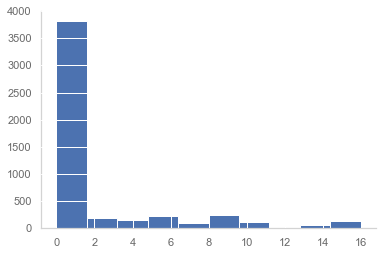

In [10]:
y.hist()

In [11]:
np.unique(y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16])

In [12]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.3,random_state = 49)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3500, 7697), (1500, 7697), (3500,), (1500,))

## Bayes naïf

In [13]:
NaiveBayes = naive_bayes.GaussianNB().fit(X_train, y_train)
y_pred_train=NaiveBayes.predict(X_train)
y_pred_test=NaiveBayes.predict(X_test)
y_pred_train.shape,y_pred_test.shape

((3500,), (1500,))

In [14]:
np.unique(y_pred_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16])

(array([2473.,  157.,  116.,  179.,   74.,  168.,   95.,    0.,   59.,
         179.]),
 array([ 0. ,  1.6,  3.2,  4.8,  6.4,  8. ,  9.6, 11.2, 12.8, 14.4, 16. ]),
 <BarContainer object of 10 artists>)

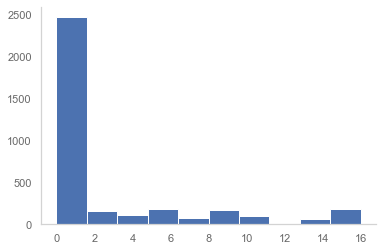

In [15]:
plt.hist(y_pred_train)

In [16]:
# scores exactitude, r2
accuracy = accuracy_score(y_test, y_pred_test) 
r2 = r2_score(y_test,y_pred_test)
accuracy, r2

(0.6473333333333333, -1.315055443716545)

In [17]:
np.unique(y_test), np.unique(y_pred_test)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16]))

In [18]:
dfConfusion=confusionMatrixAcc(y_test, y_pred_test)
dfConfusion.sort_values(by='Class')

,Class,TP,FP,TN,FN,TPR,FPR,Accuracy
0,0,893,246,78,230,0.795191,0.759259,0.671044
1,1,3,17,968,16,0.157895,0.017259,0.967131
2,2,4,14,967,27,0.129032,0.014271,0.959486
3,3,4,13,967,24,0.142857,0.013265,0.963294
4,4,14,27,957,34,0.291667,0.027439,0.940891
5,5,6,21,965,31,0.162162,0.021298,0.949169
6,6,10,15,961,15,0.400000,0.015369,0.970030
7,7,8,19,963,19,0.296296,0.019348,0.962339
8,8,8,19,963,32,0.200000,0.019348,0.950098
9,9,5,11,966,35,0.125000,0.011259,0.954769


## Random forest

In [19]:
rfc = RandomForestClassifier(random_state=0)

rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [20]:
y_pred_train=rfc.predict(X_train)
y_pred_test=rfc.predict(X_test)
np.unique(y_pred_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16])

(array([2616.,   57.,   51.,   74.,  104.,   84.,   75.,   65.,   81.,
          75.,   40.,   35.,    0.,   22.,   18.,  103.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16.]),
 <BarContainer object of 16 artists>)

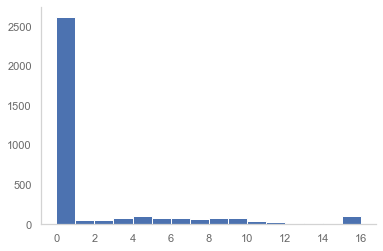

In [21]:
bins=len(np.unique(y_pred_train))
plt.hist(y_pred_train,bins=bins)

In [22]:
# scores exactitude, r2
accuracy = accuracy_score(y_test, y_pred_test) 
r2 = r2_score(y_test,y_pred_test)
accuracy, r2

(0.8026666666666666, 0.08684326676848853)

In [23]:
y_test.shape,y_pred_test.shape

((1500,), (1500,))

In [24]:
np.unique(y_test), np.unique(y_pred_test)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15]))

In [25]:
dfConfusion=confusionMatrixAcc(y_test, y_pred_test)
dfConfusion.sort_values(by='Class')

,Class,TP,FP,TN,FN,TPR,FPR,Accuracy
0,0,1083,234,121,40,0.964381,0.659155,0.814614
1,1,2,3,1202,17,0.105263,0.002490,0.983660
2,2,9,5,1195,22,0.290323,0.004167,0.978067
3,3,8,1,1196,20,0.285714,0.000835,0.982857
4,4,22,10,1182,26,0.458333,0.008389,0.970968
5,5,7,11,1197,30,0.189189,0.009106,0.967068
6,6,11,4,1193,14,0.440000,0.003342,0.985270
7,7,10,3,1194,17,0.370370,0.002506,0.983660
8,8,21,4,1183,19,0.525000,0.003370,0.981255
9,9,3,3,1201,37,0.075000,0.002492,0.967846


## Regression logistique

In [26]:
lr = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear')

In [27]:
np.unique(y_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16])

In [28]:
lr.fit(X_train, y_train)

LogisticRegression(multi_class='ovr', solver='liblinear')

In [29]:
y_pred_train=lr.predict(X_train)
y_pred_test=lr.predict(X_test)
np.unique(y_pred_train)

array([0])

(array([], dtype=float64), array([0]), <BarContainer object of 0 artists>)

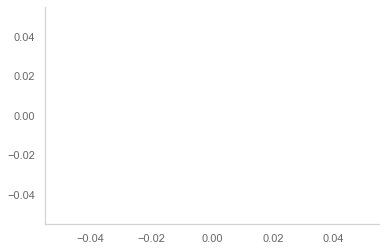

In [30]:
bins=np.unique(y_pred_train)
plt.hist(y_pred_train,bins=bins)

In [31]:
# scores exactitude, r2
accuracy = accuracy_score(y_test, y_pred_test) 
r2 = r2_score(y_test,y_pred_test)
accuracy, r2

(0.7486666666666667, -0.23484459119507473)

In [32]:
dfConfusion=confusionMatrixAcc(y_test, y_pred_test)
dfConfusion

,Class,TP,FP,TN,FN,TPR,FPR,Accuracy
0,0,1123,377,0,0,1.0,1.0,0.748667


## XGBoost

In [33]:
model=XGBClassifier(eta=0.1,n_estimators=100,max_depth=4,subsample=1,colsample_bytree=0.8,objective='multi:softmax')
model.fit(X_train,y_train)

/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:07:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, eta=0.1, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.100000001, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [34]:
y_pred_train=model.predict(X_train)
y_pred_test=model.predict(X_test)
np.unique(y_pred_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15])

(array([3065.,   27.,   87.,   40.,   79.,   57.,   73.,   12.,    8.,
          52.]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ]),
 <BarContainer object of 10 artists>)

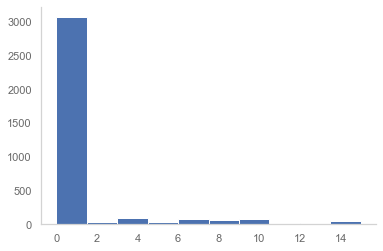

In [35]:
plt.hist(y_pred_train)

In [36]:
# scores exactitude, r2
accuracy = accuracy_score(y_test, y_pred_test) 
r2 = r2_score(y_test,y_pred_test)
accuracy, r2

(0.792, 0.009267639502178793)

In [37]:
dfConfusion=confusionMatrixAcc(y_test, y_pred_test)
dfConfusion.sort_values(by='Class')

,Class,TP,FP,TN,FN,TPR,FPR,Accuracy
0,0,1093,264,95,30,0.973286,0.735376,0.801619
1,1,2,1,1186,17,0.105263,0.000842,0.985075
2,2,7,7,1181,24,0.225806,0.005892,0.974569
3,3,9,1,1179,19,0.321429,0.000847,0.983444
4,4,15,7,1173,33,0.312500,0.005932,0.967427
5,5,4,7,1184,33,0.108108,0.005877,0.967427
6,6,9,5,1179,16,0.360000,0.004223,0.982630
7,7,8,3,1180,19,0.296296,0.002536,0.981818
8,8,19,3,1169,21,0.475000,0.002560,0.980198
9,9,5,3,1183,35,0.125000,0.002530,0.969005


## Reseau de neurones

In [38]:
tf.config.run_functions_eagerly(True) #activation de l'execution en mode dynamique

# Parametres du reseau de neurones
EPOCHS = 60 # iterations
BATCH_SIZE = 256 #taille de l'echantillon par iteration
VERBOSE = 1
NB_CLASSES = 20   # nombre de neurones/classe en sortie
N_HIDDEN = 34 # nombre de neurones des couches cachees = nombre d'observations/(2*(nombre de neurones input + nombre de neurones output))
VALIDATION_SPLIT = 0.2 # pourcentage des donnees d'entrainement reservées pour la validation
DROPOUT = 0.3

INPUT_SHAPE = X_train.shape

In [39]:
INPUT_SHAPE[1]

7697

In [40]:
# Creation du modele
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(INPUT_SHAPE[1],
    input_shape=INPUT_SHAPE,
    name='input_layer', 
    activation='relu'))
model.add(tf.keras.layers.Dense(N_HIDDEN,
    name='hidden_layer_1',
    activation='relu'))
model.add(tf.keras.layers.Dense(N_HIDDEN,
    name='hidden_layer_2',
    activation='relu'))
model.add(tf.keras.layers.Dense(NB_CLASSES,
    name='output_layer',
    activation='softmax'))

2021-11-18 16:11:12.437586: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [41]:
# Caracteristique/description du modele
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 3500, 7697)        59251506  
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 3500, 34)          261732    
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 3500, 34)          1190      
_________________________________________________________________
output_layer (Dense)         (None, 3500, 20)          700       
Total params: 59,515,128
Trainable params: 59,515,128
Non-trainable params: 0
_________________________________________________________________


In [42]:
# Compilation
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', # methode de calcul de cout
              metrics=['mean_squared_error']) # methode d'evaluation

In [43]:
%%time
callbacks = [
  #  Objet History pour monitorer les iterations
  tf.keras.callbacks.History(),
  # Logs pour TensorBoard dans le repertoire './logs' 
  #tf.keras.callbacks.TensorBoard(log_dir='./logs') # activation des logs pour TensorBoard
]

history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS , verbose = VERBOSE, validation_split = 0.2, callbacks = callbacks)

Epoch 1/60


/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(
2021-11-18 16:11:12.844550: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


11/11 [==============================] - 5s 428ms/step - loss: 2.7842 - mean_squared_error: 16.2870 - val_loss: 1.7796 - val_mean_squared_error: 20.0573
Epoch 2/60
11/11 [==============================] - 4s 344ms/step - loss: 1.4366 - mean_squared_error: 16.9449 - val_loss: 1.6239 - val_mean_squared_error: 20.0871
Epoch 3/60
11/11 [==============================] - 4s 345ms/step - loss: 1.0831 - mean_squared_error: 17.1658 - val_loss: 1.4365 - val_mean_squared_error: 20.0692
Epoch 4/60
11/11 [==============================] - 4s 346ms/step - loss: 0.9834 - mean_squared_error: 16.7382 - val_loss: 1.4271 - val_mean_squared_error: 20.0839
Epoch 5/60
11/11 [==============================] - 4s 348ms/step - loss: 0.8261 - mean_squared_error: 15.9719 - val_loss: 1.3680 - val_mean_squared_error: 20.0796
Epoch 6/60
11/11 [==============================] - 4s 346ms/step - loss: 0.7987 - mean_squared_error: 15.8181 - val_loss: 1.3769 - val_mean_squared_error: 20.0821
Epoch 7/60
11/11 [=========

Epoch 51/60
11/11 [==============================] - 4s 347ms/step - loss: 0.0049 - mean_squared_error: 16.2624 - val_loss: 3.8383 - val_mean_squared_error: 20.0961
Epoch 52/60
11/11 [==============================] - 4s 346ms/step - loss: 0.0039 - mean_squared_error: 16.4752 - val_loss: 3.8154 - val_mean_squared_error: 20.0957
Epoch 53/60
11/11 [==============================] - 4s 345ms/step - loss: 0.0033 - mean_squared_error: 16.5343 - val_loss: 3.9001 - val_mean_squared_error: 20.0962
Epoch 54/60
11/11 [==============================] - 4s 346ms/step - loss: 0.0033 - mean_squared_error: 15.6960 - val_loss: 3.8874 - val_mean_squared_error: 20.0959
Epoch 55/60
11/11 [==============================] - 4s 345ms/step - loss: 0.0030 - mean_squared_error: 15.9131 - val_loss: 3.9598 - val_mean_squared_error: 20.0963
Epoch 56/60
11/11 [==============================] - 4s 349ms/step - loss: 0.0030 - mean_squared_error: 15.4074 - val_loss: 3.9506 - val_mean_squared_error: 20.0960
Epoch 57/6

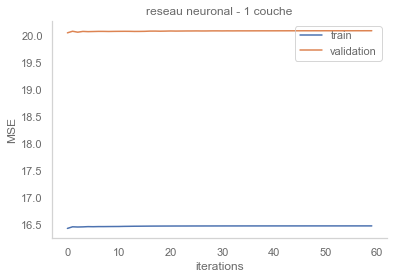

In [44]:
import matplotlib.pyplot as plt

plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('reseau neuronal - 1 couche')
plt.ylabel('MSE')
plt.xlabel('iterations')
plt.legend(['train' , 'validation'] , loc = 'upper right')
plt.show()

In [45]:
y_pred_train=np.squeeze(model.predict_classes(X_train)) #helps to get rid of useless one dimension arrays  and predict classes directly instead of probability
y_pred_test=np.squeeze(model.predict_classes(X_test)) #helps to get rid of useless one dimension arrays  and predict classes directly instead of probability

/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [46]:
np.unique(y_pred_test),len(y_pred_test)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15]), 1500)

In [47]:
# scores exactitude, r2
accuracy = accuracy_score(y_test, y_pred_test) 
r2 = r2_score(y_test,y_pred_test)
accuracy, r2

(0.7293333333333333, -0.3948087432165315)

In [48]:
r2_score_tf(y_test,y_pred_test)

<tf.Tensor: shape=(), dtype=float64, numpy=-0.3380330635952937>

In [49]:
dfConfusion=confusionMatrixAcc(y_test, y_pred_test)
dfConfusion

,Class,TP,FP,TN,FN,TPR,FPR,Accuracy
13,14,3,2,1091,6,0.333333,0.001830,0.992740
12,13,3,5,1091,6,0.333333,0.004562,0.990045
10,10,8,10,1086,9,0.470588,0.009124,0.982929
1,1,2,8,1092,17,0.105263,0.007273,0.977659
7,7,11,10,1083,16,0.407407,0.009149,0.976786
11,11,4,13,1090,14,0.222222,0.011786,0.975914
2,2,11,8,1083,20,0.354839,0.007333,0.975045
3,3,6,15,1088,22,0.214286,0.013599,0.967286
8,8,14,11,1080,26,0.350000,0.010082,0.967286
6,6,14,28,1080,11,0.560000,0.025271,0.965578


## LDA

In [50]:
# instanciation du modele
model=LatentDirichletAllocation(n_components=20)

lda_matrix = model.fit_transform(X_train)

# recuperation des composantes
lda_components=model.components_

# termes des thematiques
terms = dfTFIDFCommon.columns

for index, component in enumerate(lda_components):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:7]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ",top_terms_list)

Topic 0:  ['server side', 'ajax request', 'list item', 'multiple instance', 'primary key', 'array object', 'source control']
Topic 1:  ['binary file', 'best way', 'class use', 'excel file', 'android sdk', 'submit form', 'design class']
Topic 2:  ['net mvc', 'asp net', 'memory leak', 'template function', 'file folder', 'php mysql', 'htmlstring mvchtmlstring']
Topic 3:  ['insert string', 'jquery javascript', 'string string', 'element array', 'asp net', 'first line', 'single page']
Topic 4:  ['sql query', 'unit test', 'byte array', 'custom control', 'write unit', 'rel nofollow', 'version number']
Topic 5:  ['get file', 'optimize query', 'move file', 'method use', 'phone number', 'int int', 'wcf service']
Topic 6:  ['android studio', 'file use', 'property object', 'pas value', 'text file', 'list control', 'share library']
Topic 7:  ['get record', 'prepared statement', 'http response', 'column value', 'use powershell', 'run command', 'alternative robohelp']
Topic 8:  ['regular expression', 